![](http://i67.tinypic.com/2jcbwcw.png)

## Data-X: EDA of Ocean Trash Level

Plastic Pollution in the World’s Oceans: More than 5 Trillion Plastic Pieces Weighing over 250,000 Tons Afloat at Sea

This is a map of the field locations where count density was measured between 2007-2013 using surface manta tows. Count density (pieces km22; see colors in legend) of marine plastic debris for various plastic size class (0.33-1.00, 1.01-4.75, 4.76-200, and over 200 mm).
In the following EDA we only examine the trash data from 2012.
The underlying research paper can be found here: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0111913

## Import packages

In [1]:
# No warnings
import warnings
warnings.filterwarnings('ignore') # Filter out warnings

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

pd.set_option('display.max_columns', 100) # Print 100 Pandas columns

import matplotlib.pyplot as plt
import matplotlib.cm
 
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB # Gaussian Naive Bays
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier #stochastic gradient descent
from sklearn.tree import DecisionTreeClassifier

### Define fancy plot to look at distributions

In [3]:
# Special distribution plot (will be used later)
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()
    plt.tight_layout()

## Input Data

In [4]:
data = pd.read_excel('PlasticMarinePollutionGlobalDataset.xlsx')


# Exploratory Data Anlysis (EDA)
We will analyze the data to see how we can work with it and what makes sense.

In [5]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 16 columns):
Date            1571 non-null object
Latitude        1571 non-null float64
Longitude       1571 non-null float64
CD1  (/km^2)    680 non-null object
CD2  (/km^2)    680 non-null object
CD3  (/km^2)    808 non-null object
CD4  (/km^2)    1090 non-null object
WD1 (g/km^2)    442 non-null object
WD2 (g/km^2)    442 non-null object
WD3 (g/km^2)    570 non-null object
WD4 (g/km^2)    888 non-null object
Sea State       1214 non-null object
Source          1571 non-null object
Info            1571 non-null object
Comments        37 non-null object
Unnamed: 15     377 non-null object
dtypes: float64(2), object(14)
memory usage: 196.6+ KB


,Date,Latitude,Longitude,CD1 (/km^2),CD2 (/km^2),CD3 (/km^2),CD4 (/km^2),WD1 (g/km^2),WD2 (g/km^2),WD3 (g/km^2),WD4 (g/km^2),Sea State,Source,Info,Comments,Unnamed: 15
0,NaN,NaN,NaN,.335-.999 mm,1.00-4.75 mm,4.75-200 mm,>200 mm,.335-.999 mm,1.00-4.75 mm,4.75-200 mm,>200 mm,(Beaufort Scale),NaN,NaN,NaN,NaN
1,2010-09-01 00:00:00,19.9432,-64.5649,58103,21259.9,2226.17,NaN,4.45,26.83,4.23,NaN,2.5,M. Eriksen,NAG10-SM001,NaN,NaN
2,2010-09-01 00:00:00,20.2173,-64.3828,6639.79,4031.3,1067.11,NaN,1.04,28.69,40.79,NaN,2,M. Eriksen,NAG10-SM002,NaN,NaN
3,2010-09-01 00:00:00,20.4521,-64.1968,15246.7,12147.8,991.66,NaN,2.57,42.62,3503.27,NaN,2,M. Eriksen,NAG10-SM003,NaN,NaN
4,2010-10-01 00:00:00,21.1293,-63.8333,5347.35,6851.29,1420.39,NaN,1.15,12.86,4.26,NaN,2,M. Eriksen,NAG10-SM004,NaN,NaN


In [6]:
print(data.columns.values)

['Date' 'Latitude' 'Longitude' 'CD1  (/km^2)' 'CD2  (/km^2)'
 'CD3  (/km^2)' 'CD4  (/km^2)' 'WD1 (g/km^2)' 'WD2 (g/km^2)'
 'WD3 (g/km^2)' 'WD4 (g/km^2)' 'Sea State' 'Source' 'Info' 'Comments'
 'Unnamed: 15']


In [7]:
print('Number of NaNs in the dataframe:\n',data.isnull().sum())

Number of NaNs in the dataframe:
 Date               1
Latitude           1
Longitude          1
CD1  (/km^2)     892
CD2  (/km^2)     892
CD3  (/km^2)     764
CD4  (/km^2)     482
WD1 (g/km^2)    1130
WD2 (g/km^2)    1130
WD3 (g/km^2)    1002
WD4 (g/km^2)     684
Sea State        358
Source             1
Info               1
Comments        1535
Unnamed: 15     1195
dtype: int64


In [8]:
#Drop unwanted columns and transform date column
data_d = data.iloc[1:].drop(columns=['Sea State','Source', 'Info','Comments','Unnamed: 15'])
data_d['Date'] = pd.to_datetime(data_d['Date'])
data_d.head()

,Date,Latitude,Longitude,CD1 (/km^2),CD2 (/km^2),CD3 (/km^2),CD4 (/km^2),WD1 (g/km^2),WD2 (g/km^2),WD3 (g/km^2),WD4 (g/km^2)
1,2010-09-01,19.9432,-64.5649,58103,21259.9,2226.17,NaN,4.45,26.83,4.23,NaN
2,2010-09-01,20.2173,-64.3828,6639.79,4031.3,1067.11,NaN,1.04,28.69,40.79,NaN
3,2010-09-01,20.4521,-64.1968,15246.7,12147.8,991.66,NaN,2.57,42.62,3503.27,NaN
4,2010-10-01,21.1293,-63.8333,5347.35,6851.29,1420.39,NaN,1.15,12.86,4.26,NaN
5,2010-10-01,21.4730,-63.5899,4090.58,5317.76,409.06,NaN,0.48,29.63,4.36,NaN


In [9]:
#Data 2012
data_2012 = data_d[(data_d['Date'] > '2012-01-01') & (data_d['Date'] <= '2012-12-31')]
data_2012.head()

,Date,Latitude,Longitude,CD1 (/km^2),CD2 (/km^2),CD3 (/km^2),CD4 (/km^2),WD1 (g/km^2),WD2 (g/km^2),WD3 (g/km^2),WD4 (g/km^2)
177,2012-01-29,33.0118,-167.9233,30557.6,45116.4,3519.72,NaN,5.12,202.86,1014.32,NaN
286,2012-07-05,14.5523,160.7231,1632.46,4570.9,979.48,NaN,0.46,3.92,44.31,NaN
287,2012-08-05,15.2175,159.9003,0,2772.96,554.59,NaN,0,17.19,16.64,NaN
288,2012-08-05,15.7937,159.2056,0,359.73,1438.91,NaN,0,0,0.36,NaN
289,2012-08-05,16.4507,158.5566,0,387.59,0,NaN,0,3.29,0,NaN


In [10]:
#fill NaN with mean of each column
data_nn = data_2012[data_d.columns[1:]].apply(lambda x: x.fillna(x.mean()),axis=0)
data_nn.head()

,Latitude,Longitude,CD1 (/km^2),CD2 (/km^2),CD3 (/km^2),CD4 (/km^2),WD1 (g/km^2),WD2 (g/km^2),WD3 (g/km^2),WD4 (g/km^2)
177,33.0118,-167.9233,30557.56,45116.39,3519.72,28.807687,5.12,202.86,1014.32,12422.969197
286,14.5523,160.7231,1632.46,4570.90,979.48,28.807687,0.46,3.92,44.31,12422.969197
287,15.2175,159.9003,0.00,2772.96,554.59,28.807687,0.00,17.19,16.64,12422.969197
288,15.7937,159.2056,0.00,359.73,1438.91,28.807687,0.00,0.00,0.36,12422.969197
289,16.4507,158.5566,0.00,387.59,0.00,28.807687,0.00,3.29,0.00,12422.969197


In [11]:
data_nn.describe(include='all')

,Latitude,Longitude,CD1 (/km^2),CD2 (/km^2),CD3 (/km^2),CD4 (/km^2),WD1 (g/km^2),WD2 (g/km^2),WD3 (g/km^2),WD4 (g/km^2)
count,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000
mean,0.960057,65.946360,2152.921446,7773.220194,810.412293,28.807687,1.761429,84.104857,355.623030,12422.969197
std,26.432204,124.249552,4699.362629,15822.217994,1321.948259,64.873827,0.798266,58.176871,528.843972,25644.518615
min,-42.844800,-178.561300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-23.759450,-79.113575,0.000000,3462.842564,11.600000,0.000000,1.761429,84.104857,355.623030,722.115000
50%,5.760500,119.065100,2152.921446,7773.220194,810.412293,2.000000,1.761429,84.104857,355.623030,12422.969197
75%,29.646150,155.203350,2152.921446,7773.220194,810.412293,28.807687,1.761429,84.104857,355.623030,12422.969197
max,41.670300,179.450000,62977.870000,275858.220000,16574.771250,682.300000,13.160000,1187.420000,7939.600000,308741.060000


In [12]:
#Restrict the dataset to the pacific ocean region
pacific = data_nn.loc[data_d['Longitude'].between(-179, -114)].loc[data_nn['Latitude'].between(14, 53)]
pacific.head()

,Latitude,Longitude,CD1 (/km^2),CD2 (/km^2),CD3 (/km^2),CD4 (/km^2),WD1 (g/km^2),WD2 (g/km^2),WD3 (g/km^2),WD4 (g/km^2)
177,33.0118,-167.9233,30557.560000,45116.390000,3519.720000,28.807687,5.120000,202.860000,1014.32000,12422.969197
318,30.2817,-176.8333,14421.280000,17457.330000,759.010000,28.807687,0.870000,51.350000,31.88000,12422.969197
319,31.1333,-174.3002,13779.540000,22259.260000,1766.610000,28.807687,0.670000,146.450000,1837.98000,12422.969197
478,30.0095,-178.5613,2152.921446,7773.220194,810.412293,202.400000,1.761429,84.104857,355.62303,11386.790000
479,30.0400,-178.4100,2152.921446,7773.220194,810.412293,195.420000,1.761429,84.104857,355.62303,11706.230000


In [13]:
#Calculate total accumulation per Lat/Long-point + create new column
pacific['Total Accumulation'] = pacific['WD1 (g/km^2)'] + pacific['WD2 (g/km^2)'] + pacific['WD3 (g/km^2)'] + pacific['WD4 (g/km^2)']
pacific['Total Count'] = pacific[pacific.columns[3:6]].sum(axis=1)
pacific.head()

,Latitude,Longitude,CD1 (/km^2),CD2 (/km^2),CD3 (/km^2),CD4 (/km^2),WD1 (g/km^2),WD2 (g/km^2),WD3 (g/km^2),WD4 (g/km^2),Total Accumulation,Total Count
177,33.0118,-167.9233,30557.560000,45116.390000,3519.720000,28.807687,5.120000,202.860000,1014.32000,12422.969197,13645.269197,48664.917687
318,30.2817,-176.8333,14421.280000,17457.330000,759.010000,28.807687,0.870000,51.350000,31.88000,12422.969197,12507.069197,18245.147687
319,31.1333,-174.3002,13779.540000,22259.260000,1766.610000,28.807687,0.670000,146.450000,1837.98000,12422.969197,14408.069197,24054.677687
478,30.0095,-178.5613,2152.921446,7773.220194,810.412293,202.400000,1.761429,84.104857,355.62303,11386.790000,11828.279316,8786.032487
479,30.0400,-178.4100,2152.921446,7773.220194,810.412293,195.420000,1.761429,84.104857,355.62303,11706.230000,12147.719316,8779.052487


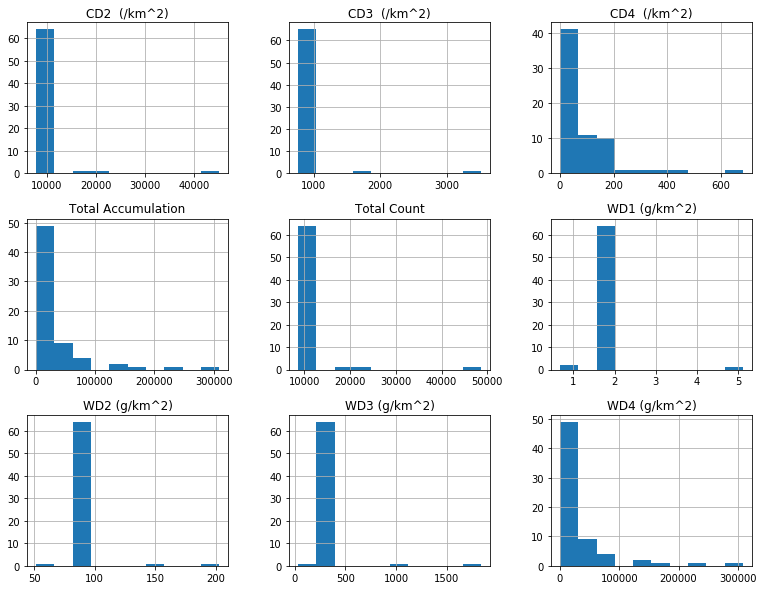

In [14]:
pacific[pacific.columns[3:]].hist(figsize=(13,10))
plt.show()

In [15]:
# #looking at the individual distributions by percentiles
# f, ax1 = plt.subplots(nrows=3,ncols=3, figsize=(12,8))
# # ax1[0,0].boxplot(pacific['CD1 (/km^2)'])
# # ax1[0,1].boxplot(pacific['CD2 (/km^2)'])
# # ax1[0,2].boxplot(pacific['CD3 (/km^2)'])
# # ax1[1,0].boxplot(pacific['CD4 (/km^2)'])
# ax1[1,1].boxplot(pacific['WD1 (g/km^2)'])
# ax1[1,2].boxplot(pacific['WD2 (g/km^2)'])
# ax1[2,0].boxplot(pacific['WD3 (g/km^2)'])
# ax1[2,1].boxplot(pacific['WD4 (g/km^2)'])
# ax1[2,2].boxplot(pacific['Total Accumulation'])
# ax1[2,2].boxplot(pacific['Total Count']);

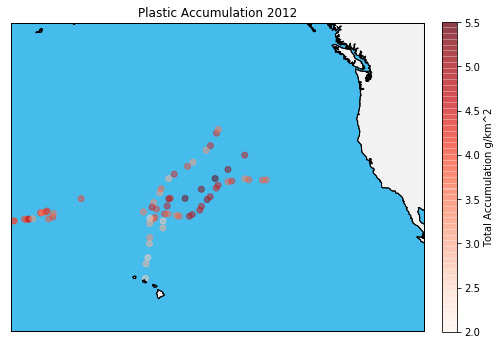

In [16]:
fig, ax = plt.subplots(figsize=(8,12))
m = Basemap(resolution='l', # c, l, i, h, f or None
            projection='merc',
            lat_0=33.5, lon_0=-146.5,
            llcrnrlon=-179, llcrnrlat=14 , urcrnrlon=-114, urcrnrlat=53)
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines();

#trash data
lat = pacific['Latitude'].values
lon = pacific['Longitude'].values
accum1 = pacific['WD1 (g/km^2)'].values
accum2 = pacific['WD2 (g/km^2)'].values
accum3 = pacific['WD3 (g/km^2)'].values
accum4 = pacific['WD4 (g/km^2)'].values
accumulation = pacific['Total Accumulation'].values
#count = pacific['Total Count'].values

#scatter plot trash data
m.scatter(lon, lat, latlon=True,
          c=np.log10(accumulation),
          cmap='Reds', alpha=0.5);

# m.scatter(lon, lat, latlon=True,
#           c=np.log10(accumulation), s=count/100,
#           cmap='Reds', alpha=0.5);

#colorbar and legend
plt.colorbar(fraction=0.0347, pad=0.04,label=r'Total Accumulation g/km^2')
plt.clim(2, 5.5)
matplotlib.pyplot.title('Plastic Accumulation 2012', fontdict=None, loc='center', pad=None);

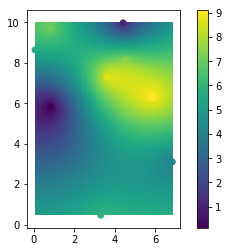

In [17]:
import scipy.interpolate

# Generate data:
x, y, z = 10 * np.random.random((3,10))

# Set up a regular grid of interpolation points
xi, yi = np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate
rbf = scipy.interpolate.Rbf(x, y, z, function='linear')
zi = rbf(xi, yi)

plt.imshow(zi, vmin=z.min(), vmax=z.max(), origin='lower',
           extent=[x.min(), x.max(), y.min(), y.max()])
plt.scatter(x, y, c=z)
plt.colorbar()
plt.show()

To Do

1. you could cluster your data points identified by the 8 characteristic plastic waste variables (so that you get an idea, what kind of areas there are and how they are distributed); you could depict these classes on the map too; so – for example – you would cluster data points to 4 different clusters and then check their centroids (sort of mean values for each cluster); from these values you could determine if these clusters are different enough so that they represent different “modes” of plastic debris in the ocean (you should also check the number of data points in each cluster)

2. you could maybe try and learn some simple models to insert missing data (i.e. where you have CD values, but no WD, you could try and model WD with CD), you could use decision trees or linear regression

3. you could check trajectories by the years and see, whether we can use this data to compare, what was going on between the years

4. you could then maybe check averages over the years to find if there is an indication of positive trend (although, this value would be – scientifically speaking – of a very small value)

5. you could try and make a plot of your data (not data points) but extrapolated over a larger area (maybe something like this: https://stackoverflow.com/questions/9008370/python-2d-contour-plot-from-3-lists-x-y-and-rho)

In [18]:
data_by_year = data_d #.set_index('Date')
data_by_year.head()

,Date,Latitude,Longitude,CD1 (/km^2),CD2 (/km^2),CD3 (/km^2),CD4 (/km^2),WD1 (g/km^2),WD2 (g/km^2),WD3 (g/km^2),WD4 (g/km^2)
1,2010-09-01,19.9432,-64.5649,58103,21259.9,2226.17,NaN,4.45,26.83,4.23,NaN
2,2010-09-01,20.2173,-64.3828,6639.79,4031.3,1067.11,NaN,1.04,28.69,40.79,NaN
3,2010-09-01,20.4521,-64.1968,15246.7,12147.8,991.66,NaN,2.57,42.62,3503.27,NaN
4,2010-10-01,21.1293,-63.8333,5347.35,6851.29,1420.39,NaN,1.15,12.86,4.26,NaN
5,2010-10-01,21.4730,-63.5899,4090.58,5317.76,409.06,NaN,0.48,29.63,4.36,NaN


In [19]:
#group data by years
data_by_year['Date'] = pd.to_datetime(data_by_year['Date'])
data_by_year['Year'] = data_by_year['Date'].dt.year


In [20]:
#number of datapoints per year
df_by_year = data_by_year.groupby('Year')
df_by_year['Year'].count()

Year
2007     25
2008    410
2009    110
2010    223
2011    242
2012    394
2013    167
Name: Year, dtype: int64

In [21]:
data_by_year_nn = data_by_year.fillna(0,axis=0).loc[data_by_year['Longitude'].between(-179, -114)].loc[data_by_year['Latitude'].between(14, 53)].drop(['Date'], axis=1)
data_by_year_nn['Total Accumulation'] = data_by_year_nn['WD1 (g/km^2)'] + data_by_year_nn['WD2 (g/km^2)'] + data_by_year_nn['WD3 (g/km^2)'] + data_by_year_nn['WD4 (g/km^2)']
data_by_year_nn['Total Count'] = data_by_year_nn[pacific.columns[3:6]].sum(axis=1)
data_by_year_nn.head()

,Latitude,Longitude,CD1 (/km^2),CD2 (/km^2),CD3 (/km^2),CD4 (/km^2),WD1 (g/km^2),WD2 (g/km^2),WD3 (g/km^2),WD4 (g/km^2),Year,Total Accumulation,Total Count
140,37.2045,-133.8650,15506.45,18552.36,1107.60,0.0,2.90,36.88,61.06,0.0,2007,100.84,19659.96
141,37.1755,-133.9495,32472.93,68218.32,14348.50,0.0,8.84,297.77,1158.28,0.0,2007,1464.89,82566.82
142,38.1515,-137.4531,118621.69,97000.01,14282.21,0.0,13.69,88.07,3654.46,0.0,2007,3756.22,111282.22
143,38.6913,-141.7720,17257.50,18881.74,2436.35,0.0,1.89,35.90,37.76,0.0,2007,75.55,21318.09
144,38.6878,-142.0264,5100.93,14353.77,1660.77,0.0,1.87,22.04,224.67,0.0,2007,248.58,16014.54


In [22]:
result = data_by_year_nn.sort_values(by=['Total Count'])
result.loc[result['Total Count'] > 0, 'Total Count'] = 1
result.head(100)

,Latitude,Longitude,CD1 (/km^2),CD2 (/km^2),CD3 (/km^2),CD4 (/km^2),WD1 (g/km^2),WD2 (g/km^2),WD3 (g/km^2),WD4 (g/km^2),Year,Total Accumulation,Total Count
534,31.6442,-158.0152,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,2010,0.00,0.0
616,39.2167,-142.8500,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,2011,0.00,0.0
618,38.8500,-134.1000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,2011,0.00,0.0
619,38.5833,-130.1333,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,2011,0.00,0.0
640,36.3092,-150.9315,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,2011,0.00,0.0
646,46.6500,-151.7167,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,2011,0.00,0.0
650,38.0007,-141.9933,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,2011,0.00,0.0
615,39.3333,-147.3167,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,2011,0.00,0.0
652,36.6393,-128.1462,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,2011,0.00,0.0
654,24.3667,-156.1667,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,2011,0.00,0.0


In [23]:
data_by_year_nn.describe()

,Latitude,Longitude,CD1 (/km^2),CD2 (/km^2),CD3 (/km^2),CD4 (/km^2),WD1 (g/km^2),WD2 (g/km^2),WD3 (g/km^2),WD4 (g/km^2),Year,Total Accumulation,Total Count
count,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000
mean,33.088021,-152.202177,17143.567781,25402.584726,2797.544491,26.214047,3.300574,143.319008,564.914830,8924.807206,2009.924282,9636.341619,28226.343264
std,5.119997,10.755887,52065.062582,63358.232210,7550.979763,74.510166,10.417206,584.790116,2087.127709,27629.538230,1.458684,27496.254850,69638.416975
min,18.158700,-178.907200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2007.000000,0.000000,0.000000
25%,30.867500,-157.743900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2009.000000,133.485000,6.220000
50%,34.050000,-153.264500,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,113.340000,2010.000000,1250.110000,43.700000
75%,36.233350,-144.830800,6877.895000,17490.935000,1568.950000,18.290000,1.530000,46.830000,49.360000,5665.235000,2011.000000,7192.880000,18950.130000
max,46.650000,-119.800000,478350.990000,391763.530000,65028.350000,693.960000,100.410000,9278.230000,21516.300000,308741.060000,2012.000000,308741.060000,419966.400000


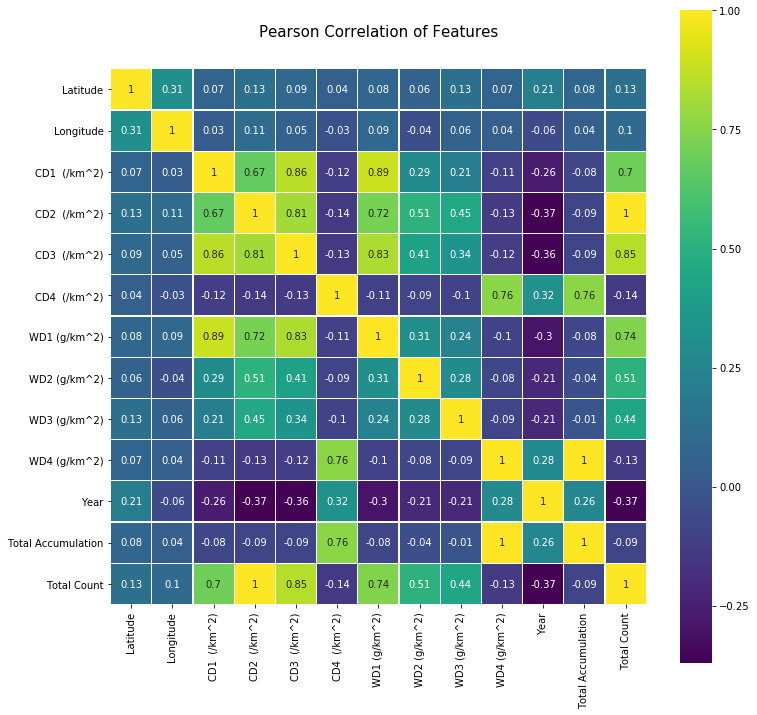

In [24]:
import seaborn as sns
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(data_by_year_nn.corr().round(2)\
            ,linewidths=0.1,vmax=1.0, square=True, cmap=colormap, \
            linecolor='white', annot=True);

In [25]:
df_2007 = data_by_year_nn[data_by_year_nn['Year']==[2007]]
df_2007.head()

,Latitude,Longitude,CD1 (/km^2),CD2 (/km^2),CD3 (/km^2),CD4 (/km^2),WD1 (g/km^2),WD2 (g/km^2),WD3 (g/km^2),WD4 (g/km^2),Year,Total Accumulation,Total Count
140,37.2045,-133.8650,15506.45,18552.36,1107.60,0.0,2.90,36.88,61.06,0.0,2007,100.84,19659.96
141,37.1755,-133.9495,32472.93,68218.32,14348.50,0.0,8.84,297.77,1158.28,0.0,2007,1464.89,82566.82
142,38.1515,-137.4531,118621.69,97000.01,14282.21,0.0,13.69,88.07,3654.46,0.0,2007,3756.22,111282.22
143,38.6913,-141.7720,17257.50,18881.74,2436.35,0.0,1.89,35.90,37.76,0.0,2007,75.55,21318.09
144,38.6878,-142.0264,5100.93,14353.77,1660.77,0.0,1.87,22.04,224.67,0.0,2007,248.58,16014.54


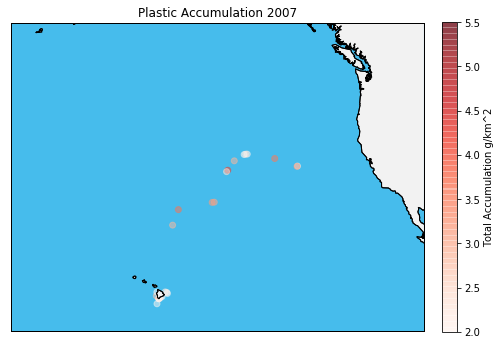

In [26]:
fig, ax = plt.subplots(figsize=(8,12))
m = Basemap(resolution='l', # c, l, i, h, f or None
            projection='merc',
            lat_0=33.5, lon_0=-146.5,
            llcrnrlon=-179, llcrnrlat=14 , urcrnrlon=-114, urcrnrlat=53)
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines();

#trash data
lat = df_2007['Latitude'].values
lon = df_2007['Longitude'].values
accum1 = df_2007['WD1 (g/km^2)'].values
accum2 = df_2007['WD2 (g/km^2)'].values
accum3 = df_2007['WD3 (g/km^2)'].values
accum4 = df_2007['WD4 (g/km^2)'].values
accumulation = df_2007['Total Accumulation'].values
#count = pacific['Total Count'].values

#scatter plot trash data
m.scatter(lon, lat, latlon=True,
          c=np.log10(accumulation),
          cmap='Reds', alpha=0.5);

# m.scatter(lon, lat, latlon=True,
#           c=np.log10(accumulation), s=count/100,
#           cmap='Reds', alpha=0.5);

#colorbar and legend
plt.colorbar(fraction=0.0347, pad=0.04,label=r'Total Accumulation g/km^2')
plt.clim(2, 5.5)
matplotlib.pyplot.title('Plastic Accumulation 2007', fontdict=None, loc='center', pad=None);

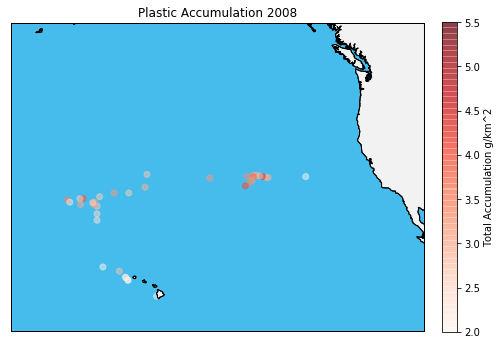

In [27]:
df_2008 = data_by_year_nn[data_by_year_nn['Year']==[2008]]
df_2008.head()
fig, ax = plt.subplots(figsize=(8,12))
m = Basemap(resolution='l', # c, l, i, h, f or None
            projection='merc',
            lat_0=33.5, lon_0=-146.5,
            llcrnrlon=-179, llcrnrlat=14 , urcrnrlon=-114, urcrnrlat=53)
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines();

#trash data
lat = df_2008['Latitude'].values
lon = df_2008['Longitude'].values
accum1 = df_2008['WD1 (g/km^2)'].values
accum2 = df_2008['WD2 (g/km^2)'].values
accum3 = df_2008['WD3 (g/km^2)'].values
accum4 = df_2008['WD4 (g/km^2)'].values
accumulation = df_2008['Total Accumulation'].values
#count = pacific['Total Count'].values

#scatter plot trash data
m.scatter(lon, lat, latlon=True,
          c=np.log10(accumulation),
          cmap='Reds', alpha=0.5);

# m.scatter(lon, lat, latlon=True,
#           c=np.log10(accumulation), s=count/100,
#           cmap='Reds', alpha=0.5);

#colorbar and legend
plt.colorbar(fraction=0.0347, pad=0.04,label=r'Total Accumulation g/km^2')
plt.clim(2, 5.5)
matplotlib.pyplot.title('Plastic Accumulation 2008', fontdict=None, loc='center', pad=None);

In [28]:
df_2009 = data_by_year_nn[data_by_year_nn['Year']==[2009]]
df_2009.head()

,Latitude,Longitude,CD1 (/km^2),CD2 (/km^2),CD3 (/km^2),CD4 (/km^2),WD1 (g/km^2),WD2 (g/km^2),WD3 (g/km^2),WD4 (g/km^2),Year,Total Accumulation,Total Count
202,25.1070,-128.1097,14058.05,12993.04,3834.01,0.0,3.07,7.22,32.38,0.0,2009,42.67,16827.05
203,24.2205,-128.3530,2491.81,4600.27,766.71,0.0,0.35,4.60,0.77,0.0,2009,5.72,5366.98
204,23.5677,-130.3722,4561.04,7367.83,2105.09,0.0,0.67,7.30,9.44,0.0,2009,17.41,9472.92
205,24.6048,-146.3870,1045.21,1254.26,209.04,0.0,0.22,4.92,23.31,0.0,2009,28.45,1463.30
206,24.5445,-146.4777,1983.31,1873.13,330.55,0.0,0.24,2.66,114.26,0.0,2009,117.16,2203.68


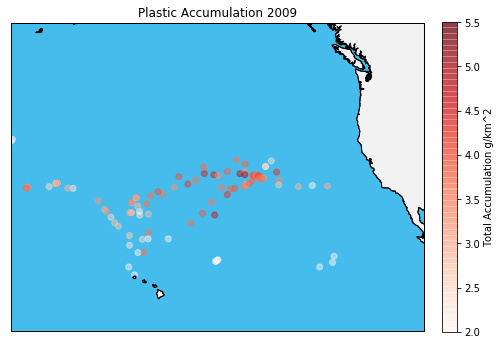

In [29]:
fig, ax = plt.subplots(figsize=(8,12))
m = Basemap(resolution='l', # c, l, i, h, f or None
            projection='merc',
            lat_0=33.5, lon_0=-146.5,
            llcrnrlon=-179, llcrnrlat=14 , urcrnrlon=-114, urcrnrlat=53)
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines();

#trash data
lat = df_2009['Latitude'].values
lon = df_2009['Longitude'].values
accum1 = df_2009['WD1 (g/km^2)'].values
accum2 = df_2009['WD2 (g/km^2)'].values
accum3 = df_2009['WD3 (g/km^2)'].values
accum4 = df_2009['WD4 (g/km^2)'].values
accumulation = df_2009['Total Accumulation'].values
#count = pacific['Total Count'].values

#scatter plot trash data
m.scatter(lon, lat, latlon=True,
          c=np.log10(accumulation),
          cmap='Reds', alpha=0.5);

# m.scatter(lon, lat, latlon=True,
#           c=np.log10(accumulation), s=count/100,
#           cmap='Reds', alpha=0.5);

#colorbar and legend
plt.colorbar(fraction=0.0347, pad=0.04,label=r'Total Accumulation g/km^2')
plt.clim(2, 5.5)
matplotlib.pyplot.title('Plastic Accumulation 2009', fontdict=None, loc='center', pad=None);

In [30]:
df_2010 = data_by_year_nn[data_by_year_nn['Year']==[2010]]
df_2010.head()

,Latitude,Longitude,CD1 (/km^2),CD2 (/km^2),CD3 (/km^2),CD4 (/km^2),WD1 (g/km^2),WD2 (g/km^2),WD3 (g/km^2),WD4 (g/km^2),Year,Total Accumulation,Total Count
226,34.4452,-176.4782,44996.4,78743.7,937.43,0.00,10.22,89.06,15.0,0.00,2010,114.28,79681.13
534,31.6442,-158.0152,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,2010,0.00,0.00
535,33.1199,-158.1481,0.0,0.0,0.00,1.37,0.00,0.00,0.0,68.60,2010,68.60,1.37
536,33.6833,-158.0500,0.0,0.0,0.00,6.97,0.00,0.00,0.0,1216.62,2010,1216.62,6.97
537,34.0500,-157.9833,0.0,0.0,0.00,1.26,0.00,0.00,0.0,2581.77,2010,2581.77,1.26


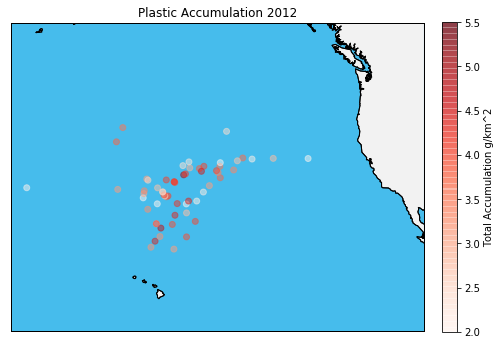

In [31]:
fig, ax = plt.subplots(figsize=(8,12))
m = Basemap(resolution='l', # c, l, i, h, f or None
            projection='merc',
            lat_0=33.5, lon_0=-146.5,
            llcrnrlon=-179, llcrnrlat=14 , urcrnrlon=-114, urcrnrlat=53)
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines();

#trash data
lat = df_2010['Latitude'].values
lon = df_2010['Longitude'].values
accum1 = df_2010['WD1 (g/km^2)'].values
accum2 = df_2010['WD2 (g/km^2)'].values
accum3 = df_2010['WD3 (g/km^2)'].values
accum4 = df_2010['WD4 (g/km^2)'].values
accumulation = df_2010['Total Accumulation'].values
#count = pacific['Total Count'].values

#scatter plot trash data
m.scatter(lon, lat, latlon=True,
          c=np.log10(accumulation),
          cmap='Reds', alpha=0.5);

# m.scatter(lon, lat, latlon=True,
#           c=np.log10(accumulation), s=count/100,
#           cmap='Reds', alpha=0.5);

#colorbar and legend
plt.colorbar(fraction=0.0347, pad=0.04,label=r'Total Accumulation g/km^2')
plt.clim(2, 5.5)
matplotlib.pyplot.title('Plastic Accumulation 2012', fontdict=None, loc='center', pad=None);

In [32]:
df_2011 = data_by_year_nn[data_by_year_nn['Year']==[2011]]
df_2011.head()

,Latitude,Longitude,CD1 (/km^2),CD2 (/km^2),CD3 (/km^2),CD4 (/km^2),WD1 (g/km^2),WD2 (g/km^2),WD3 (g/km^2),WD4 (g/km^2),Year,Total Accumulation,Total Count
270,31.5383,-156.8608,6798.71,24281.09,5827.46,0.0,0.87,0.29,903.26,0.0,2011,904.42,30108.55
271,32.2027,-156.8332,6957.08,21280.47,5320.12,0.0,1.19,162.55,308.57,0.0,2011,472.31,26600.59
272,39.1247,-156.9162,4548.72,24397.70,2894.64,0.0,1.98,74.60,6083.67,0.0,2011,6160.25,27292.34
273,40.2005,-156.7070,13470.24,29695.75,2755.28,0.0,1.07,109.38,84.92,0.0,2011,195.37,32451.03
274,41.0398,-156.2367,16016.88,66276.76,3313.84,0.0,2.71,265.05,38.66,0.0,2011,306.42,69590.60


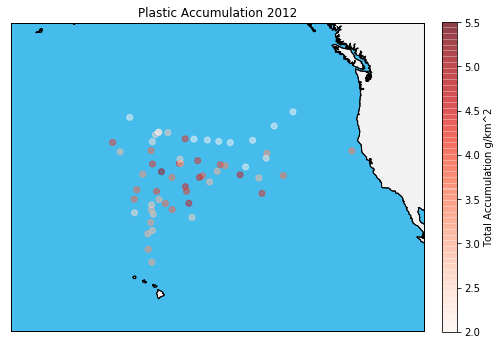

In [33]:
fig, ax = plt.subplots(figsize=(8,12))
m = Basemap(resolution='l', # c, l, i, h, f or None
            projection='merc',
            lat_0=33.5, lon_0=-146.5,
            llcrnrlon=-179, llcrnrlat=14 , urcrnrlon=-114, urcrnrlat=53)
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines();

#trash data
lat = df_2011['Latitude'].values
lon = df_2011['Longitude'].values
accum1 = df_2011['WD1 (g/km^2)'].values
accum2 = df_2011['WD2 (g/km^2)'].values
accum3 = df_2011['WD3 (g/km^2)'].values
accum4 = df_2011['WD4 (g/km^2)'].values
accumulation = df_2011['Total Accumulation'].values
#count = pacific['Total Count'].values

#scatter plot trash data
m.scatter(lon, lat, latlon=True,
          c=np.log10(accumulation),
          cmap='Reds', alpha=0.5);

# m.scatter(lon, lat, latlon=True,
#           c=np.log10(accumulation), s=count/100,
#           cmap='Reds', alpha=0.5);

#colorbar and legend
plt.colorbar(fraction=0.0347, pad=0.04,label=r'Total Accumulation g/km^2')
plt.clim(2, 5.5)
matplotlib.pyplot.title('Plastic Accumulation 2012', fontdict=None, loc='center', pad=None);

In [34]:
df_2012 = data_by_year_nn[data_by_year_nn['Year']==[2012]]
df_2012.head()

,Latitude,Longitude,CD1 (/km^2),CD2 (/km^2),CD3 (/km^2),CD4 (/km^2),WD1 (g/km^2),WD2 (g/km^2),WD3 (g/km^2),WD4 (g/km^2),Year,Total Accumulation,Total Count
177,33.0118,-167.9233,30557.56,45116.39,3519.72,0.00,5.12,202.86,1014.32,0.00,2012,1222.30,48636.11
318,30.2817,-176.8333,14421.28,17457.33,759.01,0.00,0.87,51.35,31.88,0.00,2012,84.10,18216.34
319,31.1333,-174.3002,13779.54,22259.26,1766.61,0.00,0.67,146.45,1837.98,0.00,2012,1985.10,24025.87
478,30.0095,-178.5613,0.00,0.00,0.00,202.40,0.00,0.00,0.00,11386.79,2012,11386.79,202.40
479,30.0400,-178.4100,0.00,0.00,0.00,195.42,0.00,0.00,0.00,11706.23,2012,11706.23,195.42


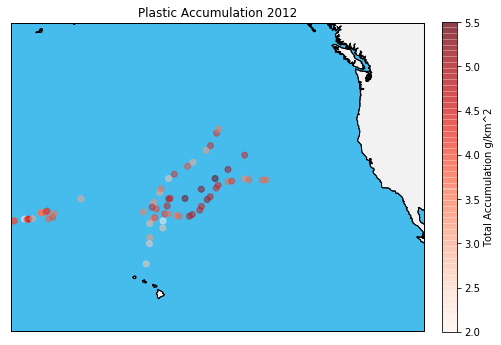

In [35]:
fig, ax = plt.subplots(figsize=(8,12))
m = Basemap(resolution='l', # c, l, i, h, f or None
            projection='merc',
            lat_0=33.5, lon_0=-146.5,
            llcrnrlon=-179, llcrnrlat=14 , urcrnrlon=-114, urcrnrlat=53)
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines();

#trash data
lat = df_2012['Latitude'].values
lon = df_2012['Longitude'].values
accum1 = df_2012['WD1 (g/km^2)'].values
accum2 = df_2012['WD2 (g/km^2)'].values
accum3 = df_2012['WD3 (g/km^2)'].values
accum4 = df_2012['WD4 (g/km^2)'].values
accumulation = df_2012['Total Accumulation'].values
#count = pacific['Total Count'].values

#scatter plot trash data
m.scatter(lon, lat, latlon=True,
          c=np.log10(accumulation),
          cmap='Reds', alpha=0.5);

# m.scatter(lon, lat, latlon=True,
#           c=np.log10(accumulation), s=count/100,
#           cmap='Reds', alpha=0.5);

#colorbar and legend
plt.colorbar(fraction=0.0347, pad=0.04,label=r'Total Accumulation g/km^2')
plt.clim(2, 5.5)
matplotlib.pyplot.title('Plastic Accumulation 2012', fontdict=None, loc='center', pad=None);

In [36]:
df_2013 = data_by_year_nn[data_by_year_nn['Year']==[2012]]
df_2013.head()

,Latitude,Longitude,CD1 (/km^2),CD2 (/km^2),CD3 (/km^2),CD4 (/km^2),WD1 (g/km^2),WD2 (g/km^2),WD3 (g/km^2),WD4 (g/km^2),Year,Total Accumulation,Total Count
177,33.0118,-167.9233,30557.56,45116.39,3519.72,0.00,5.12,202.86,1014.32,0.00,2012,1222.30,48636.11
318,30.2817,-176.8333,14421.28,17457.33,759.01,0.00,0.87,51.35,31.88,0.00,2012,84.10,18216.34
319,31.1333,-174.3002,13779.54,22259.26,1766.61,0.00,0.67,146.45,1837.98,0.00,2012,1985.10,24025.87
478,30.0095,-178.5613,0.00,0.00,0.00,202.40,0.00,0.00,0.00,11386.79,2012,11386.79,202.40
479,30.0400,-178.4100,0.00,0.00,0.00,195.42,0.00,0.00,0.00,11706.23,2012,11706.23,195.42


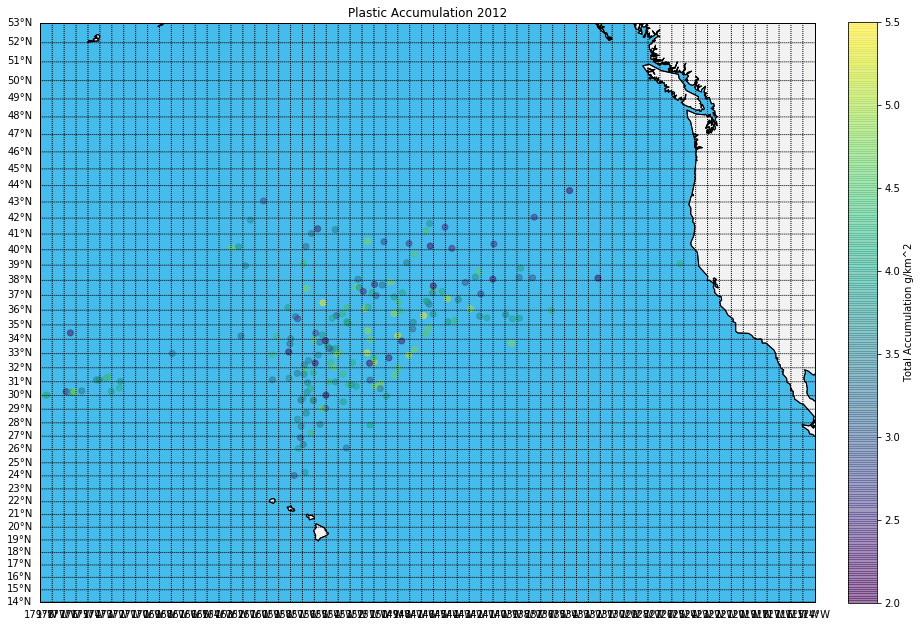

In [37]:
fig, ax = plt.subplots(figsize=(15,18))
m = Basemap(resolution='l', # c, l, i, h, f or None
            projection='merc',
            lat_0=33.5, lon_0=-146.5,
            llcrnrlon=-179, llcrnrlat=14 , urcrnrlon=-114, urcrnrlat=53)
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,90.,1.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,180.,1.),labels=[0,0,0,1]);

#trash data
lat1 = df_2013['Latitude'].values
lon1 = df_2013['Longitude'].values
accumulation1 = df_2013['Total Accumulation'].values
lat2 = df_2011['Latitude'].values
lon2 = df_2011['Longitude'].values
accumulation2 = df_2011['Total Accumulation'].values
lat3 = df_2010['Latitude'].values
lon3 = df_2010['Longitude'].values
accumulation3 = df_2010['Total Accumulation'].values
#count = pacific['Total Count'].values

#scatter plot trash data
m.scatter(lon1, lat1, latlon=True,
          c=np.log10(accumulation1), alpha=0.5);
m.scatter(lon2, lat2, latlon=True,
          c=np.log10(accumulation2), alpha=0.5);
m.scatter(lon3, lat3, latlon=True,
          c=np.log10(accumulation3), alpha=0.5);

# m.scatter(lon, lat, latlon=True,
#           c=np.log10(accumulation), s=count/100,
#           cmap='Reds', alpha=0.5);

#colorbar and legend
plt.colorbar(fraction=0.0347, pad=0.04,label=r'Total Accumulation g/km^2')
plt.clim(2, 5.5)
matplotlib.pyplot.title('Plastic Accumulation 2012', fontdict=None, loc='center', pad=None);

In [38]:
#trash data
lat13 = df_2013['Latitude'].values
lon13 = df_2013['Longitude'].values
accumulation13 = df_2013['Total Accumulation'].values
#count = pacific['Total Count'].values

#trash data
lat11= df_2011['Latitude'].values
lon11 = df_2011['Longitude'].values
accumulation12 = df_2011['Total Accumulation'].values
#count = pacific['Total Count'].values

#trash data
lat07= df_2007['Latitude'].values
lon07 = df_2007['Longitude'].values
accumulation07 = df_2007['Total Accumulation'].values
#count = pacific['Total Count'].values

#trash data
lat08= df_2008['Latitude'].values
lon08 = df_2008['Longitude'].values
accumulation08 = df_2008['Total Accumulation'].values
#count = pacific['Total Count'].values

#trash data
lat09= df_2009['Latitude'].values
lon09 = df_2009['Longitude'].values
accumulation09 = df_2009['Total Accumulation'].values
#count = pacific['Total Count'].values

#trash data
lat10= df_2010['Latitude'].values
lon10 = df_2010['Longitude'].values
accumulation10 = df_2010['Total Accumulation'].values
#count = pacific['Total Count'].values

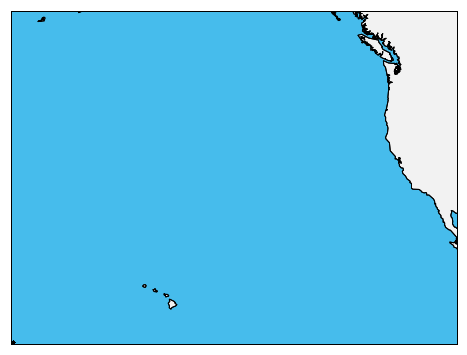

In [39]:
fig, ax = plt.subplots(figsize=(8,12))
m = Basemap(resolution='l', # c, l, i, h, f or None
            projection='merc',
            lat_0=33.5, lon_0=-146.5,
            llcrnrlon=-179, llcrnrlat=14 , urcrnrlon=-114, urcrnrlat=53)
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines();

m.scatter(lat11,lon11, c='b', marker='x', label='1')
m.scatter(lat13, lon13, c='r', marker='x', label='-1')
m.scatter(lat07, lon07, c='g', marker='x', label='-1')
m.scatter(lat08, lon08, c='y', marker='x', label='-1')
m.scatter(lat09, lon09, c='orange', marker='x', label='-1')
m.scatter(lat10, lon10, c='black', marker='x', label='-1');

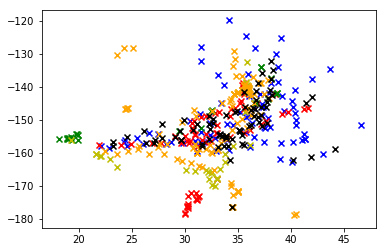

In [40]:
import matplotlib.pyplot as plt

plt.scatter(lat11,lon11, c='b', marker='x', label='1')
plt.scatter(lat13, lon13, c='r', marker='x', label='-1')
plt.scatter(lat07, lon07, c='g', marker='x', label='-1')
plt.scatter(lat08, lon08, c='y', marker='x', label='-1')
plt.scatter(lat09, lon09, c='orange', marker='x', label='-1')
plt.scatter(lat10, lon10, c='black', marker='x', label='-1');

In [41]:
X = result.drop('Total Count', axis=1) # Training & Validation data
Y = result["Total Count"] # Response / Target Variable
np.random.seed(1337) # set random seed for reproducibility

from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

(306, 12) (306,)
(77, 12) (77,)
